In [28]:
librarian::shelf(tidyverse, tidymodels, corrplot, GGally, viridis, patchwork, scales, gridExtra,
   ggridges, vip, ggbiplot, factoextra, finetune, kernlab, ranger, xgboost, janitor, Boruta,
    PCAtest, summarytools, tictoc)

In [2]:
# Set Custom Theme


theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}



In [3]:
cancer_data <- read_csv("datasets/Cancer_Data.csv") %>% 
  select(-c(id, starts_with("...")))

New names:
• `` -> `...33`
Rows: 568 Columns: 33
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): diagnosis
dbl (31): id, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, conc...
lgl  (1): ...33

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 


In [4]:
# Clean the column names using the janitor package
cancer_data <- cancer_data %>% 
  clean_names()

In [5]:
# Generate summary statistics
view(dfSummary(cancer_data))

Switching method to 'browser'
Output file written: C:\Users\oland\AppData\Local\Temp\RtmpwrIWSf\filec9c5cf7349a.html


In [6]:
# Convert the target variable to a factor

cancer_data %>%
    mutate(diagnosis = as.factor(diagnosis)) -> cancer_data

In [7]:
correlation_matrix <- cancer_data %>%
    select_if(is.numeric) %>%
    cor()

In [8]:
correlation_matrix

                         radius_mean texture_mean perimeter_mean   area_mean smoothness_mean compactness_mean concavity_mean
radius_mean              1.000000000  0.329051912    0.997842852  0.98748872      0.16252908        0.5045010     0.67590040
texture_mean             0.329051912  1.000000000    0.334846666  0.32493143     -0.01686064        0.2397721     0.30555180
perimeter_mean           0.997842852  0.334846666    1.000000000  0.98663921      0.19962065        0.5555185     0.71543155
area_mean                0.987488722  0.324931427    0.986639207  1.00000000      0.17138316        0.4971456     0.68518281
smoothness_mean          0.162529083 -0.016860636    0.199620649  0.17138316      1.00000000        0.6592250     0.52090080
compactness_mean         0.504501001  0.239772119    0.555518545  0.49714563      0.65922498        1.0000000     0.88285708
concavity_mean           0.675900403  0.305551804    0.715431554  0.68518281      0.52090080        0.8828571     1.00000000


In [9]:
## 1. Diagnostic plots
ggplot(cancer_data, aes(diagnosis, fill = diagnosis)) +
    geom_bar(width = 0.7) +
    geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
    scale_fill_viridis_d(option = "D") +
    labs(title = "Distribution of Cancer Diagnosis",
       subtitle = "Count of Malignant vs Benign Cases",
       x = "Diagnosis Type",
       y = "Number of Cases") +
    theme_custom() +
    theme(legend.position = "none") -> diagnosis_plot

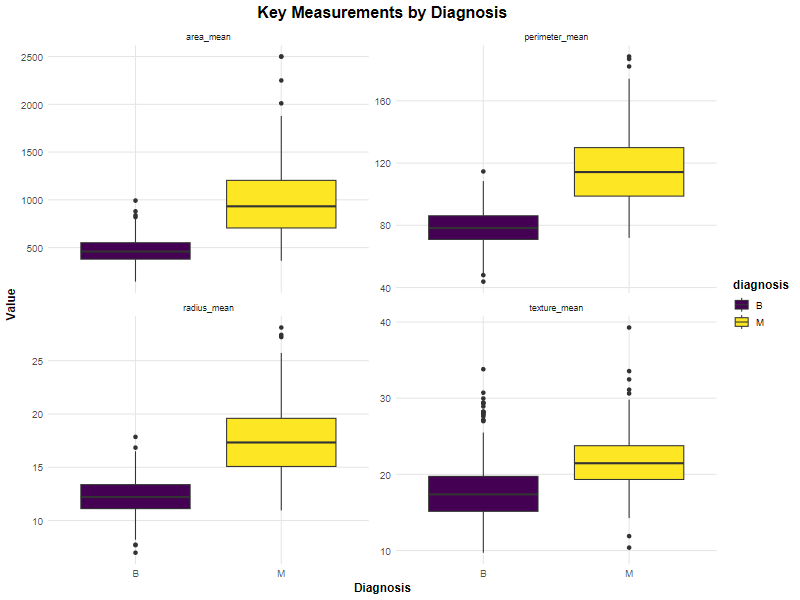

In [10]:
## Box plots
# 2. Box plots for key measurements by diagnosis
cancer_data %>%
  pivot_longer(cols = c(radius_mean, texture_mean, perimeter_mean, area_mean),
               names_to = "measurement",
               values_to = "value") %>%
  ggplot(aes(x = diagnosis, y = value, fill = diagnosis)) +
  geom_boxplot() +
  facet_wrap(~measurement, scales = "free_y") +
  theme_custom() +
  scale_fill_viridis_d(option = "D") +
  labs(title = "Key Measurements by Diagnosis",
       x = "Diagnosis",
       y = "Value")



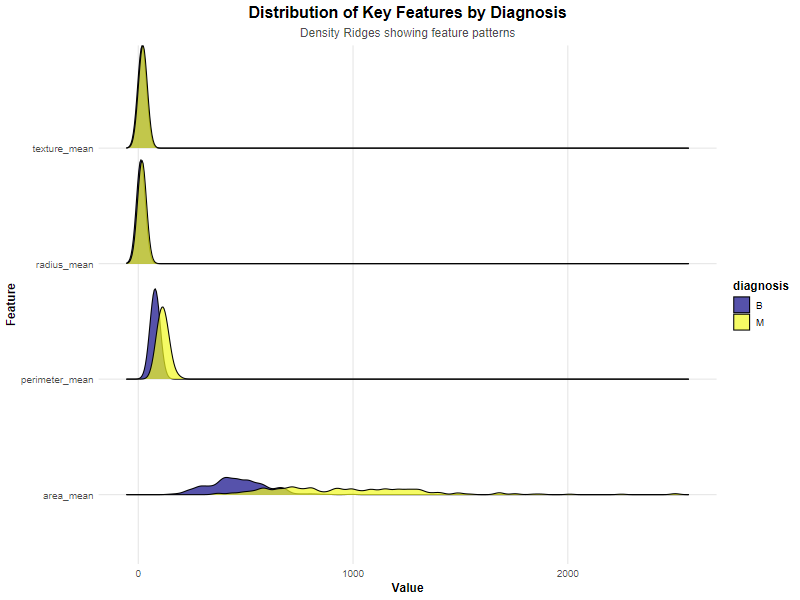

Picking joint bandwidth of 20.3

In [11]:
## Feature Density

selected_features <- c("radius_mean", "texture_mean", "perimeter_mean", "area_mean")

cancer_data %>%
    pivot_longer(cols = all_of(selected_features),
               names_to = "feature",
               values_to = "value") %>%
    ggplot(aes(value, feature, fill = diagnosis)) +
    geom_density_ridges(alpha = 0.7, scale = 0.9) +
    scale_fill_viridis_d(option = "C") +
    labs(title = "Distribution of Key Features by Diagnosis",
       subtitle = "Density Ridges showing feature patterns",
       x = "Value",
       y = "Feature") +
    theme_custom() -> density_plot

density_plot

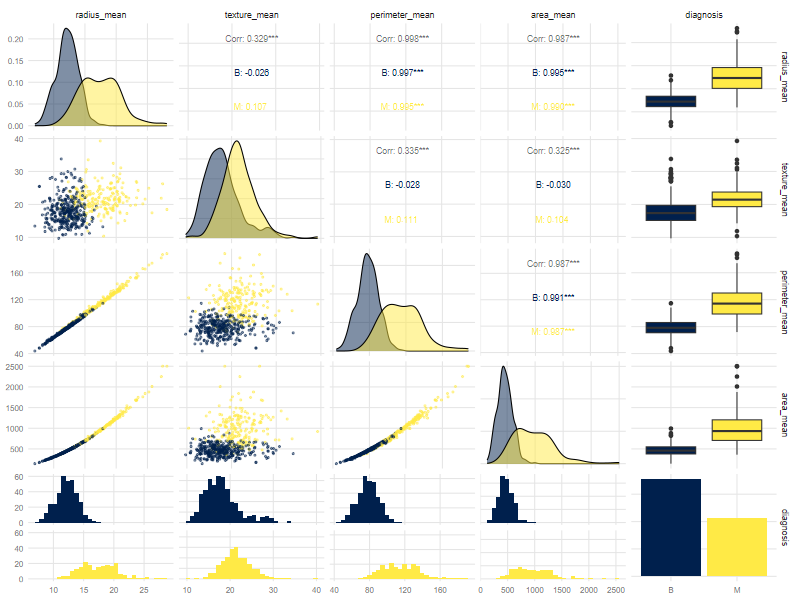

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [12]:
## Scatter Matrix

cancer_data %>%
    select(all_of(selected_features), diagnosis) %>%
    ggpairs(aes(color = diagnosis),
                  upper = list(continuous = wrap("cor", size = 3)),
                  diag = list(continuous = wrap("densityDiag", alpha = 0.5)),
                  lower = list(continuous = wrap("points", alpha = 0.5, size = 0.8))) +
    scale_fill_viridis_d(option = "E") +
    scale_color_viridis_d(option = "E") +
    theme_custom() +
    theme(axis.text = element_text(size = 8)) -> scatter_matrix
scatter_matrix

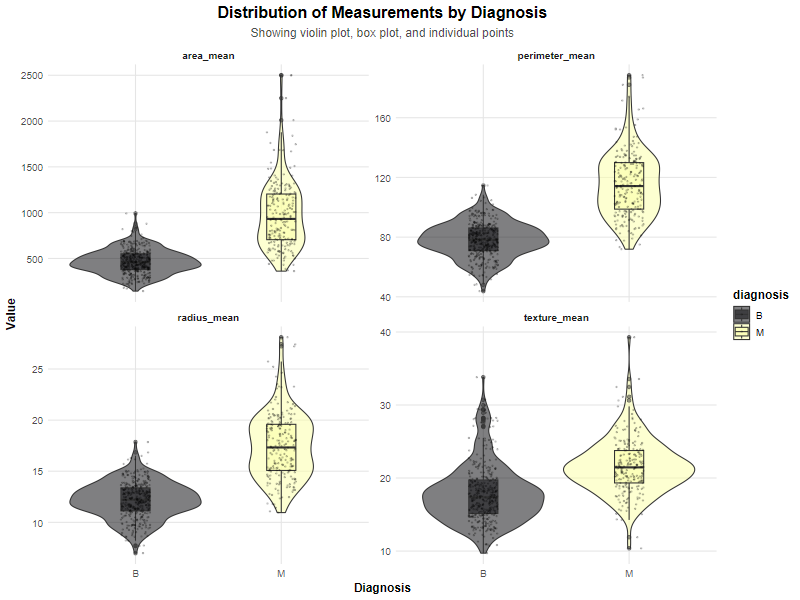

In [13]:
cancer_data %>%
  pivot_longer(cols = all_of(selected_features),
               names_to = "measurement",
               values_to = "value") %>%
  ggplot(aes(diagnosis, value, fill = diagnosis)) +
  geom_violin(alpha = 0.5) +
  geom_boxplot(width = 0.2, alpha = 0.5) +
  geom_jitter(alpha = 0.2, width = 0.1, size = 0.5) +
  facet_wrap(~measurement, scales = "free_y",
            labeller = labeller(measurement = label_wrap_gen(10))) +
  scale_fill_viridis_d(option = "B") +
  labs(title = "Distribution of Measurements by Diagnosis",
       subtitle = "Showing violin plot, box plot, and individual points",
       x = "Diagnosis",
       y = "Value") +
  theme_custom() +
  theme(strip.text = element_text(size = 10, face = "bold")) -> box_violin

box_violin

In [14]:
melted_corr <- reshape2::melt(correlation_matrix)
heatmap_plot <- ggplot(melted_corr, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_viridis(option = "D", limits = c(-1, 1), name = "Correlation") +
  theme_custom() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank()) +
  labs(title = "Feature Correlation Heatmap",
       subtitle = "Showing relationships between numerical features")

In [15]:
## Feature Importance plot
rf_recipe <- recipe(diagnosis ~ ., data = cancer_data) %>%
  step_normalize(all_predictors())

rf_model <- rand_forest() %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")

rf_wflow <- workflow() %>%
  add_recipe(rf_recipe) %>%
  add_model(rf_model)

rf_fit <- rf_wflow %>%
  fit(data = cancer_data)

rf_fit %>%
 extract_fit_parsnip() %>%
 vi() %>%
 mutate(Variable = fct_reorder(Variable, Importance)) -> importance_data

ggplot(importance_data, aes(Importance, Variable)) +
  geom_bar(stat = "identity", fill = viridis(1)) +
  labs(title = "Feature Importance from Random Forest",
       subtitle = "Showing most influential predictors",
       x = "Importance",
       y = "Feature") +
  theme_custom() -> importance_plot

Picking joint bandwidth of 20.3


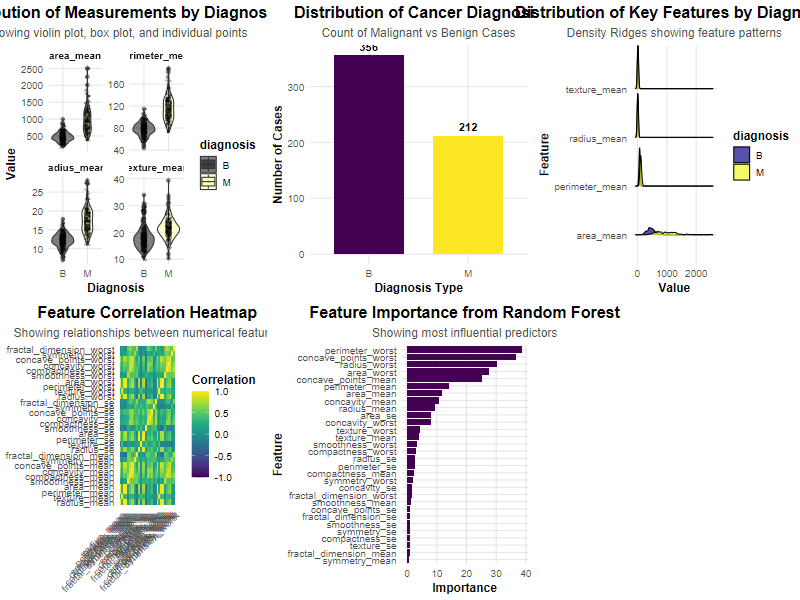

In [16]:
options(repr.plot.height = 15, repr.plot.width = 15)
grid.arrange(box_violin, diagnosis_plot, density_plot, heatmap_plot, importance_plot, nrow = 2)

# Modelling with PCA

In [17]:
features <- cancer_data %>%
 select(-diagnosis)

target <- cancer_data$diagnosis


Sampling bootstrap replicates... Please wait

Calculating confidence intervals of empirical statistics... Please wait

Sampling random permutations... Please wait

Comparing empirical statistics with their null distributions... Please wait

Test of PCA significance: 30 variables, 568 observations
1000 bootstrap replicates, 1000 random permutations

Empirical Psi = 195.9616, Max null Psi = 1.8464, Min null Psi = 1.2266, p-value = 0
Empirical Phi = 0.4746, Max null Phi = 0.0461, Min null Phi = 0.0375, p-value = 0

Empirical eigenvalue #1 = 13.2711, Max null eigenvalue = 1.58216, p-value = 0
Empirical eigenvalue #2 = 5.70585, Max null eigenvalue = 1.47135, p-value = 0
Empirical eigenvalue #3 = 2.81885, Max null eigenvalue = 1.42121, p-value = 0
Empirical eigenvalue #4 = 1.97526, Max null eigenvalue = 1.36361, p-value = 0
Empirical eigenvalue #5 = 1.6554, Max null eigenvalue = 1.33119, p-value = 0
Empirical eigenvalue #6 = 1.20596, Max null eigenvalue = 1.2951, p-value = 0.963
Empirical e

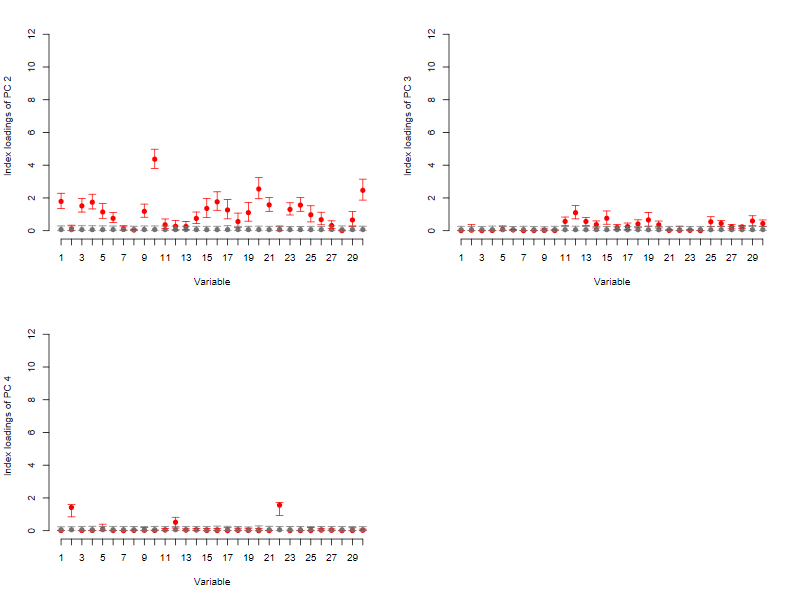

In [18]:
set.seed(42)
result <- PCAtest(
  x = features,
  nperm = 1000,
  nboot = 1000,
  alpha = 0.05,
  counter = FALSE,
  plot = TRUE
)

In [19]:
# Perform PCA
pca_result <- prcomp(features, scale. = TRUE)
summarize_pca <- function(pca_obj){
  # Calculate variance explained
  var_explained <- pca_obj$sdev^2 / sum(pca_obj$sdev^2)
  cum_var_explained <- cumsum(var_explained)

  # Create summary dataframe
  pca_summary <- data.frame(
    PC = paste0("PC", 1:length(var_explained)),
    var_explained = var_explained,
    cum_var_explained = cum_var_explained)
  
  return(pca_summary)
}

pca_summary <- summarize_pca(pca_result)

# Plot Scree Plot
plot_scree <- function(pca_summary){
  ggplot(pca_summary, aes(PC)) +
    geom_line(aes(y = var_explained), fill = viridis(1)) +
    geom_col(aes(y = cum_var_explained, group = 1), color = "red") +
    geom_point(aes(y = cum_var_explained), color = "red") +
    scale_y_continuous(
      name = "Proportion of Variance Explained",
      sec.axis = sec_axis(~., name = "Cumulative Proportion")
    ) +
    labs(title = "Scree Plot with Cumulative Variance",
          x = "Principal Component") +
    theme_custom() +
    theme(axis.text.x = element_text(angle = 45))
}

plot_pca_biplot <- function(pca_obj, data, target) {
  # Get PC scores
  scores <- as.data.frame(pca_obj$x)
  scores$diagnosis <- target
  
  # Create biplot
  ggplot(scores, aes(x = PC1, y = PC2, color = diagnosis)) +
    geom_point(alpha = 0.6) +
    stat_ellipse(level = 0.95) +
    scale_color_viridis_d() +
    labs(title = "PCA Biplot",
         x = paste0("PC1 (", round(pca_summary$var_explained[1] * 100, 1), "%)"),
         y = paste0("PC2 (", round(pca_summary$var_explained[2] * 100, 1), "%)")) +
    theme_minimal()
}

# Calculate feature contributions
feature_contributions <- as.data.frame(abs(pca_result$rotation)) %>%
  mutate(feature = rownames(.)) %>%
  pivot_longer(-feature, names_to = "PC", values_to = "contribution")

# Plot feature contributions
plot_feature_contributions <- function(feature_contributions) {
  feature_contributions %>%
    filter(PC %in% c("PC1", "PC2", "PC3")) %>%
    ggplot(aes(x = reorder(feature, contribution), y = contribution, fill = PC)) +
    geom_col(position = "dodge") +
    coord_flip() +
    scale_fill_viridis_d() +
    labs(title = "Feature Contributions to Principal Components",
         x = "Feature",
         y = "Absolute Contribution") +
    theme_minimal()
}

Warning message:
In geom_line(aes(y = var_explained), fill = viridis(1)) :
  Ignoring unknown parameters: `fill`


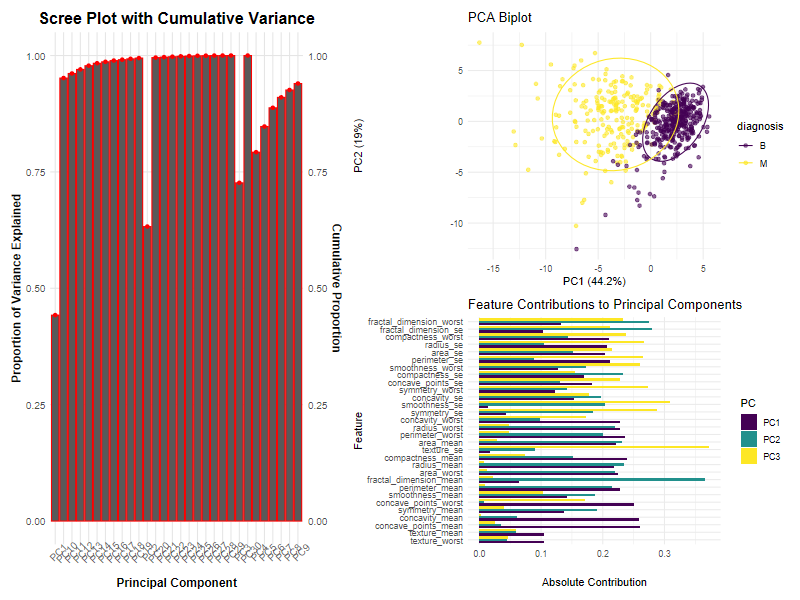

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?

In [20]:
plot_scree(pca_summary) + plot_pca_biplot(pca_result, cancer_data, cancer_data$diagnosis) / plot_feature_contributions(feature_contributions)

[1] "Summary of Kaiser Criterion Analysis:"
[1] "Number of components suggested by Kaiser criterion: 6"
[1] "Cumulative variance explained by Kaiser components: 88.77 %"
[1] "\nDetailed Component Analysis:"
  Component Eigenvalue Variance_Explained Meets_Kaiser
1       PC1  13.271102         0.44237008         TRUE
2       PC2   5.705847         0.19019489         TRUE
3       PC3   2.818852         0.09396173         TRUE
4       PC4   1.975260         0.06584200         TRUE
5       PC5   1.655397         0.05517989         TRUE
6       PC6   1.205956         0.04019852         TRUE


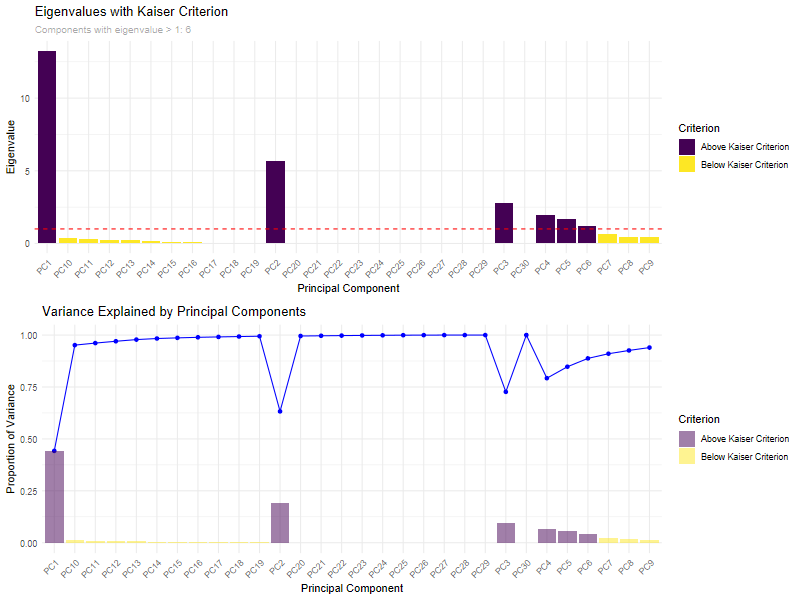

In [26]:
# Function to perform PCA analysis with Kaiser criterion
analyze_pca_kaiser <- function(data) {
  # Perform PCA
  pca_result <- prcomp(data, scale. = TRUE)
  
  # Calculate eigenvalues
  eigenvalues <- pca_result$sdev^2
  
  # Create Kaiser criterion analysis
  kaiser_analysis <- data.frame(
    Component = paste0("PC", 1:length(eigenvalues)),
    Eigenvalue = eigenvalues,
    Variance_Explained = eigenvalues / sum(eigenvalues),
    Cumulative_Variance = cumsum(eigenvalues / sum(eigenvalues)),
    Meets_Kaiser = eigenvalues > 1
  ) %>%
    mutate(
      Criterion = ifelse(Meets_Kaiser, "Above Kaiser Criterion", "Below Kaiser Criterion")
    )
  
  # Count components meeting Kaiser criterion
  n_components_kaiser <- sum(eigenvalues > 1)
  
  # Create visualization
  kaiser_plot <- ggplot(kaiser_analysis, aes(x = Component, y = Eigenvalue, fill = Criterion)) +
    geom_col() +
    geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
    scale_fill_viridis_d() +
    labs(
      title = "Eigenvalues with Kaiser Criterion",
      subtitle = paste("Components with eigenvalue > 1:", n_components_kaiser),
      x = "Principal Component",
      y = "Eigenvalue"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      plot.subtitle = element_text(size = 10, color = "darkgray")
    )
  
  # Create variance explained plot
  variance_plot <- ggplot(kaiser_analysis, aes(x = Component)) +
    geom_line(aes(y = Cumulative_Variance, group = 1), color = "blue") +
    geom_point(aes(y = Cumulative_Variance), color = "blue") +
    geom_col(aes(y = Variance_Explained, fill = Criterion), alpha = 0.5) +
    scale_fill_viridis_d() +
    labs(
      title = "Variance Explained by Principal Components",
      x = "Principal Component",
      y = "Proportion of Variance"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Calculate summary statistics
  summary_stats <- list(
    n_components_kaiser = n_components_kaiser,
    variance_explained_kaiser = sum(kaiser_analysis$Variance_Explained[kaiser_analysis$Meets_Kaiser]),
    components_summary = kaiser_analysis
  )
  
  # Return results
  return(list(
    pca_result = pca_result,
    kaiser_analysis = kaiser_analysis,
    kaiser_plot = kaiser_plot,
    variance_plot = variance_plot,
    summary_stats = summary_stats
  ))
}


# Prepare data for PCA (remove ID and target variable)
pca_data <- cancer_data %>%
  select(-diagnosis)

# Perform analysis
pca_analysis <- analyze_pca_kaiser(pca_data)

# Print summary
print("Summary of Kaiser Criterion Analysis:")
print(paste("Number of components suggested by Kaiser criterion:",
            pca_analysis$summary_stats$n_components_kaiser))
print(paste("Cumulative variance explained by Kaiser components:",
            round(pca_analysis$summary_stats$variance_explained_kaiser * 100, 2), "%"))

# Display full component summary
print("\nDetailed Component Analysis:")
print(pca_analysis$kaiser_analysis %>%
        select(Component, Eigenvalue, Variance_Explained, Meets_Kaiser) %>%
        head(pca_analysis$summary_stats$n_components_kaiser))

# Combine plots
combined_plot <- gridExtra::grid.arrange(
  pca_analysis$kaiser_plot,
  pca_analysis$variance_plot,
  ncol = 1
)

# Function to get rotations for Kaiser-selected components
get_kaiser_components <- function(pca_result, kaiser_analysis) {
  n_components <- sum(kaiser_analysis$Meets_Kaiser)
  
  # Get rotation matrix for selected components
  rotations <- pca_result$rotation[, 1:n_components, drop = FALSE]
  
  # Create summary dataframe
  rotation_summary <- as.data.frame(rotations) %>%
    mutate(Feature = rownames(.)) %>%
    pivot_longer(
      cols = -Feature,
      names_to = "Component",
      values_to = "Loading"
    ) %>%
    arrange(Component, desc(abs(Loading)))
  
  return(rotation_summary)
}

# Get loadings for Kaiser components
kaiser_loadings <- get_kaiser_components(pca_analysis$pca_result, 
                                       pca_analysis$kaiser_analysis)

# Create loadings plot
loadings_plot <- kaiser_loadings %>%
  ggplot(aes(x = reorder(Feature, abs(Loading)), y = Loading, fill = Loading)) +
  geom_col() +
  facet_wrap(~Component) +
  scale_fill_viridis() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Feature Loadings for Kaiser-Selected Components",
    x = "Feature",
    y = "Loading"
  )

# Return results as a list
results <- list(
  analysis = pca_analysis,
  loadings = kaiser_loadings,
  loadings_plot = loadings_plot
)

In [29]:
# Create PCA-based recipe for modeling
pca_recipe <- recipe(diagnosis ~ ., data = cancer_data) %>%
  step_normalize(all_predictors()) %>%
  step_pca(all_predictors(), num_comp = 6)

# Split data
data_split <- initial_split(cancer_data, prop = 0.8, strata = diagnosis)
train_data <- training(data_split)
test_data <- testing(data_split)

# Create cross-validation folds
cv_folds <- vfold_cv(train_data, v = 5, strata = diagnosis)

# Define models with tuning parameters
# 1. Random Forest
rf_spec <- rand_forest(
  mtry = tune(),
  min_n = tune(),
  trees = 1000
) %>%
  set_engine("ranger") %>%
  set_mode("classification")

# 2. XGBoost
xgb_spec <- boost_tree(
  tree_depth = tune(),
  learn_rate = tune(),
  loss_reduction = tune(),
  min_n = tune(),
  sample_size = tune(),
  trees = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

# 3. SVM
svm_spec <- svm_rbf(
  cost = tune(),
  rbf_sigma = tune()
) %>%
  set_engine("kernlab") %>%
  set_mode("classification")

# Create workflows
rf_workflow <- workflow() %>%
  add_recipe(pca_recipe) %>%
  add_model(rf_spec)

xgb_workflow <- workflow() %>%
  add_recipe(pca_recipe) %>%
  add_model(xgb_spec)

svm_workflow <- workflow() %>%
  add_recipe(pca_recipe) %>%
  add_model(svm_spec)

# Define parameter grids
rf_params <- parameters(rf_spec) %>%
  update(mtry = mtry(range = c(2, 8)))

xgb_params <- parameters(xgb_spec)

svm_params <- parameters(svm_spec)
tic()
# Perform Bayesian optimization
rf_tuned <- rf_workflow %>%
  tune_bayes(
    resamples = cv_folds,
    param_info = rf_params,
    initial = 5,
    iter = 15,
    metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),
    control = control_bayes(verbose = FALSE)
  )

xgb_tuned <- xgb_workflow %>%
  tune_bayes(
    resamples = cv_folds,
    param_info = xgb_params,
    initial = 5,
    iter = 15,
    metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),
    control = control_bayes(verbose = FALSE)
  )

svm_tuned <- svm_workflow %>%
  tune_bayes(
    resamples = cv_folds,
    param_info = svm_params,
    initial = 5,
    iter = 15,
    metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),
    control = control_bayes(verbose = FALSE)
  )
toc()
# Compare models
model_comparison <- bind_rows(
  rf_tuned %>% collect_metrics() %>% mutate(model = "Random Forest"),
  xgb_tuned %>% collect_metrics() %>% mutate(model = "XGBoost"),
  svm_tuned %>% collect_metrics() %>% mutate(model = "SVM")
)

# Plot model comparison
plot_model_comparison <- function(model_comparison) {
  model_comparison %>%
    ggplot(aes(x = model, y = mean, fill = model)) +
    geom_boxplot() +
    facet_wrap(~.metric, scales = "free_y") +
    scale_fill_viridis_d() +
    labs(title = "Model Performance Comparison",
         y = "Score") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

→ A | warning: 8 columns were requested but there were 6 predictors in the data. 6 will be used.
→ B | warning: 7 columns were requested but there were 6 predictors in the data. 6 will be used.
There were issues with some computations   A: x5   B: x5
! There are 6 tuning parameters and 5 grid points were requested.
• There are more tuning parameters than there are initial points. This is likely to cause numerical issues in the first few
  search iterations.
! The Gaussian process model is being fit using 6 features but only has 5 data points to do so. This may cause errors or a
  poor model fit.
! The Gaussian process model is being fit using 6 features but only has 6 data points to do so. This may cause errors or a
  poor model fit.
! The Gaussian process model is being fit using 6 features but only has 7 data points to do so. This may cause errors or a
  poor model fit.
687.92 sec elapsed


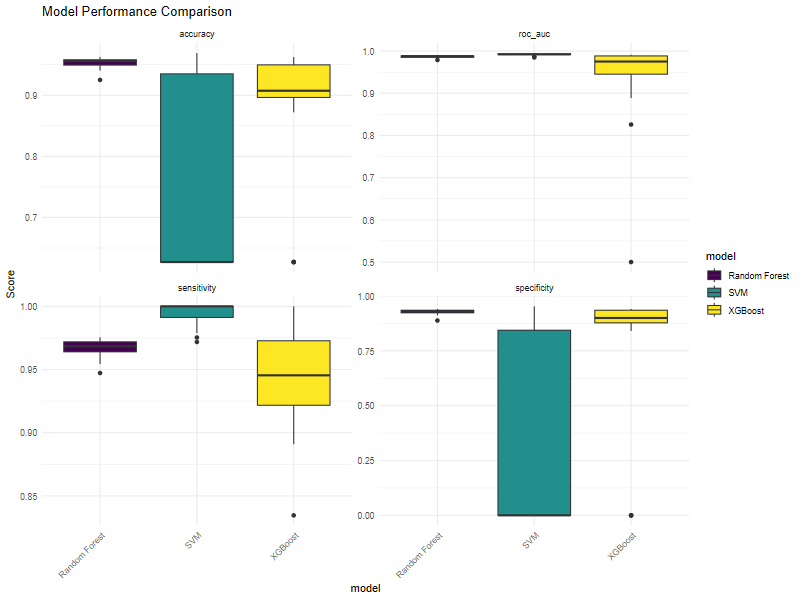

In [30]:
plot_model_comparison(model_comparison)

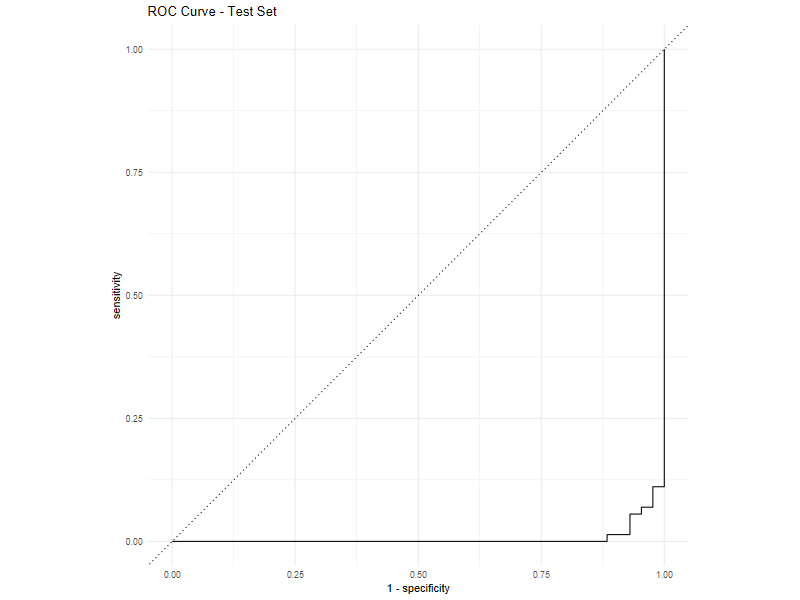

In [31]:
# Select best model and finalize workflow
rf_tuned |> 
  select_best(metric = "accuracy") -> best_rf_params
best_xgb_params <- xgb_tuned %>% select_best(metric = "accuracy")
best_svm_params <- svm_tuned %>% select_best(metric = "accuracy")

# Fit final model (using best performer)
final_workflow <- rf_workflow %>%
  finalize_workflow(best_rf_params) %>%
  fit(train_data)

# Make predictions on test set
test_predictions <- predict(final_workflow, test_data) %>%
  bind_cols(test_data)

conf_mat <- conf_mat(test_predictions, truth = diagnosis, estimate = .pred_class)
# Plot confusion matrix
autoplot(conf_mat) + 
    scale_fill_viridis_c() +
    theme_custom() +
    labs(title = "Confusion Matrix - Test Set") -> conf_mat

# Generate ROC curve
roc_curve <- final_workflow %>%
  predict(test_data, type = "prob") %>%
  bind_cols(test_data) %>%
  roc_curve(diagnosis, .pred_M) %>%
  autoplot() +
  theme_minimal() +
  labs(title = "ROC Curve - Test Set")

# Print final model metrics
final_metrics <- final_workflow %>%
  predict(test_data) %>%
  bind_cols(test_data) %>%
  metrics(truth = diagnosis, estimate = .pred_class)

# Create results list
results <- list(
  pca_summary = pca_summary,
  pca_result = pca_result,
  model_comparison = model_comparison,
  final_metrics = final_metrics,
  feature_contributions = feature_contributions,
  conf_mat = conf_mat
 
)

# Return results and plots
results 
roc_curve

# Feature Selection

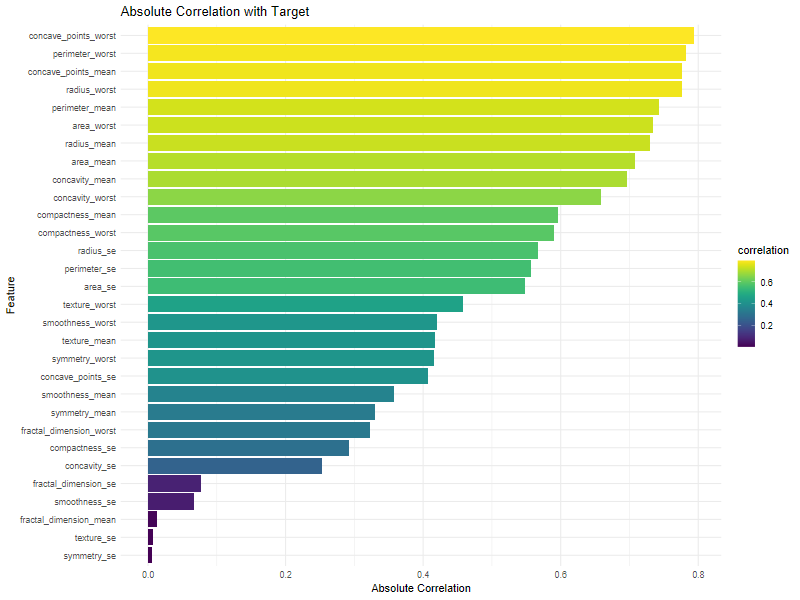

$correlations
   concave_points_worst         perimeter_worst     concave_points_mean            radius_worst          perimeter_mean 
            0.793743025             0.782794681             0.776396257             0.776306336             0.742716605 
             area_worst             radius_mean               area_mean          concavity_mean         concavity_worst 
            0.733496292             0.730060409             0.708659334             0.695972573             0.659172930 
       compactness_mean       compactness_worst               radius_se            perimeter_se                 area_se 
            0.595978844             0.590426637             0.567337589             0.556230066             0.547994823 
          texture_worst        smoothness_worst            texture_mean          symmetry_worst       concave_points_se 
            0.458414893             0.420442920             0.417610112             0.416447603             0.406972235 
        smoothness

In [32]:
# Correlation based Analysis

# Function to calculate and visualize correlations with target

correlation_analysis <- function(data, target_col) {
  target_numeric <- as.numeric(data[[target_col]]) - 1
   # Calculate correlations
  correlations <- data %>%
  select(-all_of(target_col)) %>%
  map_dbl(~cor(., target_numeric)) %>%
  sort(decreasing = TRUE)

  # Create correlation plot
corr_plot <- data.frame(
  feature = names(correlations),
  correlation = abs(correlations)
) %>%
  mutate(feature = fct_reorder(feature, correlation)) %>%
  ggplot(aes(x = correlation, y = feature, fill = correlation)) +
  geom_bar(stat = "identity") +
  scale_fill_viridis() +
  labs(title = "Absolute Correlation with Target",
       x = "Absolute Correlation",
       y = "Feature") +
  theme_minimal()

return(list(correlations = correlations, plot = corr_plot))
}

correlation_analysis(cancer_data, "diagnosis")


Attaching package: ‘entropy’

The following object is masked from ‘package:recipes’:

    discretize



There were 12 warnings (use warnings() to see them)


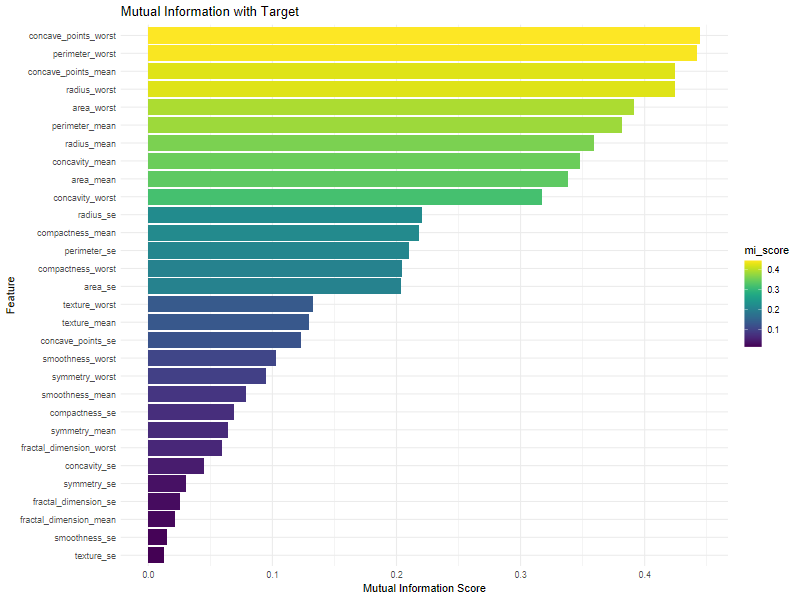

$mi_scores
            radius_mean            texture_mean          perimeter_mean               area_mean         smoothness_mean 
             0.35909532              0.12937226              0.38174819              0.33831166              0.07837251 
       compactness_mean          concavity_mean     concave_points_mean           symmetry_mean  fractal_dimension_mean 
             0.21787568              0.34764908              0.42468574              0.06412607              0.02128876 
              radius_se              texture_se            perimeter_se                 area_se           smoothness_se 
             0.22021831              0.01256823              0.21037127              0.20348067              0.01513645 
         compactness_se            concavity_se       concave_points_se             symmetry_se    fractal_dimension_se 
             0.06883623              0.04514001              0.12326677              0.03076772              0.02516816 
           radius_wor

In [33]:
# 2. Mutual Information Analysis
#----------------------------
# Function to calculate mutual information
mutual_information <- function(data, target_col) {
  library(entropy)
  
  # Calculate MI for each feature
  mi_scores <- data %>%
    select(-all_of(target_col)) %>%
    map_dbl(function(x) {
      # Discretize continuous variables
      x_bins <- cut(x, breaks = 10)
      mi.empirical(table(x_bins, data[[target_col]]))
    })
  
  # Create MI plot
  mi_plot <- data.frame(
    feature = names(mi_scores),
    mi_score = mi_scores
  ) %>%
    mutate(feature = fct_reorder(feature, mi_score)) %>%
    ggplot(aes(x = mi_score, y = feature, fill = mi_score)) +
    geom_bar(stat = "identity") +
    scale_fill_viridis() +
    labs(title = "Mutual Information with Target",
         x = "Mutual Information Score",
         y = "Feature") +
    theme_minimal()
  
  return(list(mi_scores = mi_scores, plot = mi_plot))
}

mutual_information(cancer_data, "diagnosis")

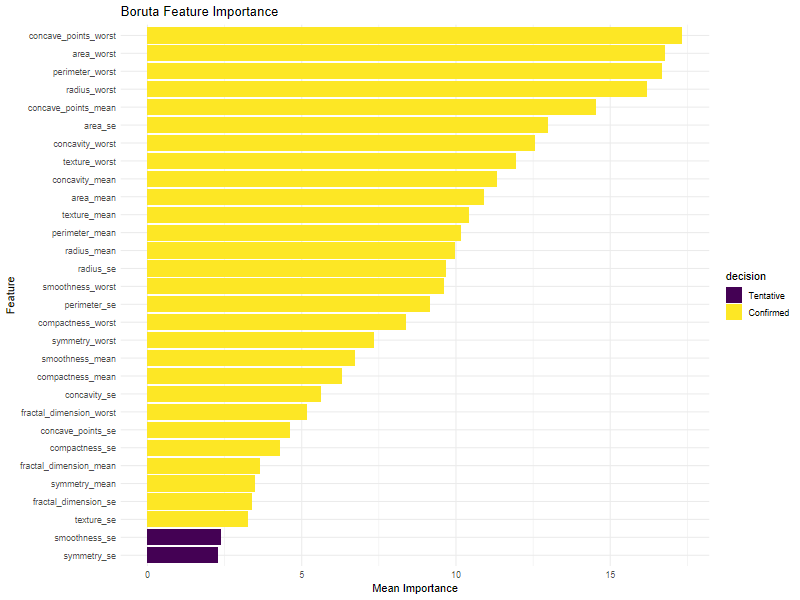

$confirmed_features
 [1] "radius_mean"             "texture_mean"            "perimeter_mean"          "area_mean"              
 [5] "smoothness_mean"         "compactness_mean"        "concavity_mean"          "concave_points_mean"    
 [9] "symmetry_mean"           "fractal_dimension_mean"  "radius_se"               "texture_se"             
[13] "perimeter_se"            "area_se"                 "compactness_se"          "concavity_se"           
[17] "concave_points_se"       "fractal_dimension_se"    "radius_worst"            "texture_worst"          
[21] "perimeter_worst"         "area_worst"              "smoothness_worst"        "compactness_worst"      
[25] "concavity_worst"         "concave_points_worst"    "symmetry_worst"          "fractal_dimension_worst"

$plot

$full_results
Boruta performed 199 iterations in 1.266785 mins.
 28 attributes confirmed important: area_mean, area_se, area_worst, compactness_mean, compactness_se and 23 more;
 No attributes deemed unimporta

In [34]:
# 3. Boruta Feature Selection
#----------------------------------------------------------------
boruta_selection <- function(data, target_col) {
  # Run Boruta
  boruta_output <- Boruta(
    x = data %>% select(-all_of(target_col)) %>% as.data.frame(),
    y = data[[target_col]],
    maxRuns = 200
  )
  
  # Get confirmed features
  confirmed_features <- getSelectedAttributes(boruta_output)
  
  # Create importance plot
  boruta_plot <- attStats(boruta_output) %>%
    as.data.frame() %>%
    mutate(feature = rownames(.)) %>%
    mutate(feature = fct_reorder(feature, meanImp)) %>%
    ggplot(aes(x = meanImp, y = feature, fill = decision)) +
    geom_bar(stat = "identity") +
    scale_fill_viridis_d() +
    labs(title = "Boruta Feature Importance",
         x = "Mean Importance",
         y = "Feature") +
    theme_minimal()
  
  return(list(
    confirmed_features = confirmed_features,
    plot = boruta_plot,
    full_results = boruta_output
  ))
}
boruta_selection(cancer_data, "diagnosis")